<a href="https://colab.research.google.com/github/uday96/EVA4-TSAI/blob/master/S9/EVA4_S9_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data augmentation using albumentations and Grad Cam implementation

Import required modules

In [ ]:
#!cd sample_data

/content/drive/My Drive/session 9/S9
config.py  EVA4_S9_Quiz.ipynb	   gradcam  models     results.py  train.py
data	   EVA4_S9_Solution.ipynb  images   README.md  test.py	   utils.py


In [ ]:
import os
os.chdir('drive/My Drive/session 9/S9')
!ls

config.py		       gradcam_incorrect_3_dog.png
correct_imgs.png	       gradcam_incorrect_4_cat.png
data			       images
EVA4_S9_Quiz.ipynb	       lr_finder.py
EVA4_S9_Solution.ipynb	       misclassified_imgs.png
gradcam			       models
gradcam_correct_0_frog.png     __pycache__
gradcam_correct_1_car.png      README.md
gradcam_correct_2_bird.png     results.py
gradcam_correct_3_car.png      test.py
gradcam_correct_4_truck.png    train.py
gradcam_incorrect_0_deer.png   utils.py
gradcam_incorrect_1_truck.png  val_accuracy_change.png
gradcam_incorrect_2_plane.png  val_loss_change.png


In [ ]:
!pip install albumentations==0.4.5

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from data.data_engine import DataEngine
from config import ModelConfig
from models.resnet import ResNet18
from train import train
from test import test
from results import plot_images, plot_graph
from utils import *
from gradcam.visualize import VisualizeCam

In [ ]:
from lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Model Configuration and Set Seed

View model configuration and set the seed

In [ ]:
# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout': 0.15,
  'epochs': 50,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.1,
  'max_lr': 0.01,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


## Data Loading and Visualization

Preprocess and load the cifar10 dataset. Visualise the dataset.

Files already downloaded and verified
Files already downloaded and verified
plane   dog  deer  deer


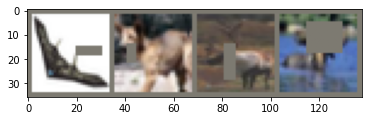

In [ ]:
data = DataEngine(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

## Model

Create model and display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,


Learning rate search finished. See the graph with {finder_name}.plot()


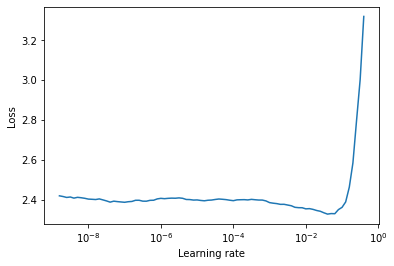

In [ ]:

device = which_device()
net = ResNet18(args.dropout)
model = net.to(device)
#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
show_model_summary(model, (3,32,32))

#lrf = LRFinder(model,optimizer, criterion, device="cuda")



criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-10, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(data.train_loader, end_lr=1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))
args.lr = best_lr

Best Loss: 2.3273217202853975
Best Learning Rate: 0.03981071705534971


## Training and Testing

Train the model and evaluate it

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,
                              verbose=True, min_lr=1e-5)

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  train_losses = []
  train_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
      scheduler.step(test_losses[-1])
  return train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs

# train and test the model
train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=464.62890625 L1_loss=103801.4765625 Loss=2.3276638984680176 Batch_id=781 Accuracy=39.15: 100%|██████████| 782/782 [01:12<00:00, 10.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0196, Accuracy: 5460/10000 (54.60%)

EPOCH: 2


L2_loss=463.4156799316406 L1_loss=97933.8125 Loss=1.5024875402450562 Batch_id=781 Accuracy=56.32: 100%|██████████| 782/782 [01:13<00:00, 10.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0152, Accuracy: 6563/10000 (65.63%)

EPOCH: 3


L2_loss=461.6904296875 L1_loss=93819.9921875 Loss=2.022057056427002 Batch_id=781 Accuracy=64.91: 100%|██████████| 782/782 [01:14<00:00, 10.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0139, Accuracy: 6906/10000 (69.06%)

EPOCH: 4


L2_loss=459.7043151855469 L1_loss=90456.859375 Loss=1.561084270477295 Batch_id=781 Accuracy=70.25: 100%|██████████| 782/782 [01:15<00:00, 10.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0105, Accuracy: 7662/10000 (76.62%)

EPOCH: 5


L2_loss=456.4168395996094 L1_loss=87787.1171875 Loss=1.1556344032287598 Batch_id=781 Accuracy=73.06: 100%|██████████| 782/782 [01:15<00:00, 10.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0112, Accuracy: 7601/10000 (76.01%)

EPOCH: 6


L2_loss=453.0285339355469 L1_loss=85726.5234375 Loss=1.6182087659835815 Batch_id=781 Accuracy=75.58: 100%|██████████| 782/782 [01:15<00:00, 10.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0099, Accuracy: 7826/10000 (78.26%)

EPOCH: 7


L2_loss=449.75115966796875 L1_loss=84354.5234375 Loss=1.4515626430511475 Batch_id=781 Accuracy=77.44: 100%|██████████| 782/782 [01:15<00:00, 10.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0095, Accuracy: 7971/10000 (79.71%)

EPOCH: 8


L2_loss=446.50048828125 L1_loss=83410.1875 Loss=2.488363742828369 Batch_id=781 Accuracy=78.90: 100%|██████████| 782/782 [01:15<00:00, 10.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0091, Accuracy: 8074/10000 (80.74%)

EPOCH: 9


L2_loss=443.0821228027344 L1_loss=82666.2265625 Loss=1.743715524673462 Batch_id=781 Accuracy=79.70: 100%|██████████| 782/782 [01:15<00:00, 10.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0083, Accuracy: 8216/10000 (82.16%)

EPOCH: 10


L2_loss=439.73779296875 L1_loss=82240.2265625 Loss=0.9193775653839111 Batch_id=781 Accuracy=80.90: 100%|██████████| 782/782 [01:15<00:00, 10.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0088, Accuracy: 8135/10000 (81.35%)

EPOCH: 11


L2_loss=436.3797607421875 L1_loss=81952.7265625 Loss=1.4826807975769043 Batch_id=781 Accuracy=82.15: 100%|██████████| 782/782 [01:15<00:00, 10.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0089, Accuracy: 8139/10000 (81.39%)

EPOCH: 12


L2_loss=433.16058349609375 L1_loss=81941.8046875 Loss=0.8968849182128906 Batch_id=781 Accuracy=82.30: 100%|██████████| 782/782 [01:15<00:00, 10.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0078, Accuracy: 8356/10000 (83.56%)

EPOCH: 13


L2_loss=429.7066650390625 L1_loss=81820.015625 Loss=1.7255018949508667 Batch_id=781 Accuracy=83.15: 100%|██████████| 782/782 [01:15<00:00, 10.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0069, Accuracy: 8487/10000 (84.87%)

EPOCH: 14


L2_loss=427.08563232421875 L1_loss=82035.46875 Loss=1.0836378335952759 Batch_id=781 Accuracy=83.71: 100%|██████████| 782/782 [01:15<00:00, 10.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8459/10000 (84.59%)

EPOCH: 15


L2_loss=424.1109924316406 L1_loss=82103.03125 Loss=1.1839838027954102 Batch_id=781 Accuracy=84.28: 100%|██████████| 782/782 [01:15<00:00, 10.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 8497/10000 (84.97%)

EPOCH: 16


L2_loss=421.1295471191406 L1_loss=82282.21875 Loss=1.0215978622436523 Batch_id=781 Accuracy=84.66: 100%|██████████| 782/782 [01:15<00:00, 10.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 84 %
Accuracy of   car : 90 %
Accuracy of  bird : 68 %
Accuracy of   cat : 65 %
Accuracy of  deer : 80 %
Accuracy of   dog : 89 %
Accuracy of  frog : 93 %
Accuracy of horse : 90 %
Accuracy of  ship : 85 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0062, Accuracy: 8683/10000 (86.83%)

EPOCH: 17


L2_loss=418.7321472167969 L1_loss=82730.9921875 Loss=1.4102418422698975 Batch_id=781 Accuracy=85.21: 100%|██████████| 782/782 [01:15<00:00, 10.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 86 %
Accuracy of   car : 98 %
Accuracy of  bird : 78 %
Accuracy of   cat : 83 %
Accuracy of  deer : 90 %
Accuracy of   dog : 62 %
Accuracy of  frog : 91 %
Accuracy of horse : 80 %
Accuracy of  ship : 97 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0067, Accuracy: 8589/10000 (85.89%)

EPOCH: 18


L2_loss=416.12359619140625 L1_loss=83175.765625 Loss=0.805801510810852 Batch_id=781 Accuracy=85.63: 100%|██████████| 782/782 [01:15<00:00, 10.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 96 %
Accuracy of  bird : 84 %
Accuracy of   cat : 61 %
Accuracy of  deer : 80 %
Accuracy of   dog : 91 %
Accuracy of  frog : 88 %
Accuracy of horse : 95 %
Accuracy of  ship : 98 %
Accuracy of truck : 84 %

Test set: Average loss: 0.0063, Accuracy: 8665/10000 (86.65%)

EPOCH: 19


L2_loss=413.0387268066406 L1_loss=83304.375 Loss=0.9154895544052124 Batch_id=781 Accuracy=85.99: 100%|██████████| 782/782 [01:15<00:00, 10.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 98 %
Accuracy of  bird : 78 %
Accuracy of   cat : 82 %
Accuracy of  deer : 67 %
Accuracy of   dog : 70 %
Accuracy of  frog : 89 %
Accuracy of horse : 84 %
Accuracy of  ship : 98 %
Accuracy of truck : 88 %

Test set: Average loss: 0.0068, Accuracy: 8580/10000 (85.80%)

EPOCH: 20


L2_loss=410.42108154296875 L1_loss=83579.515625 Loss=0.9477099180221558 Batch_id=781 Accuracy=86.39: 100%|██████████| 782/782 [01:15<00:00, 10.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 97 %
Accuracy of  bird : 70 %
Accuracy of   cat : 77 %
Accuracy of  deer : 88 %
Accuracy of   dog : 77 %
Accuracy of  frog : 90 %
Accuracy of horse : 95 %
Accuracy of  ship : 88 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0064, Accuracy: 8661/10000 (86.61%)

Epoch    20: reducing learning rate of group 0 to 3.9811e-03.
EPOCH: 21


L2_loss=408.0911865234375 L1_loss=82428.140625 Loss=0.8147547245025635 Batch_id=781 Accuracy=90.50: 100%|██████████| 782/782 [01:15<00:00, 10.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 97 %
Accuracy of  bird : 86 %
Accuracy of   cat : 81 %
Accuracy of  deer : 87 %
Accuracy of   dog : 83 %
Accuracy of  frog : 96 %
Accuracy of horse : 94 %
Accuracy of  ship : 95 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0044, Accuracy: 9061/10000 (90.61%)

EPOCH: 22


L2_loss=405.8909912109375 L1_loss=81464.3671875 Loss=0.8992499113082886 Batch_id=781 Accuracy=91.99: 100%|██████████| 782/782 [01:15<00:00, 10.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 96 %
Accuracy of  bird : 83 %
Accuracy of   cat : 88 %
Accuracy of  deer : 88 %
Accuracy of   dog : 88 %
Accuracy of  frog : 92 %
Accuracy of horse : 93 %
Accuracy of  ship : 95 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0041, Accuracy: 9136/10000 (91.36%)

EPOCH: 23


L2_loss=403.7257995605469 L1_loss=80604.0859375 Loss=0.7490724325180054 Batch_id=781 Accuracy=92.34: 100%|██████████| 782/782 [01:15<00:00, 10.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 89 %
Accuracy of   cat : 71 %
Accuracy of  deer : 92 %
Accuracy of   dog : 80 %
Accuracy of  frog : 97 %
Accuracy of horse : 95 %
Accuracy of  ship : 87 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0041, Accuracy: 9145/10000 (91.45%)

EPOCH: 24


L2_loss=401.5517578125 L1_loss=79817.1171875 Loss=0.9709311127662659 Batch_id=781 Accuracy=92.76: 100%|██████████| 782/782 [01:15<00:00, 10.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 95 %
Accuracy of  bird : 90 %
Accuracy of   cat : 91 %
Accuracy of  deer : 89 %
Accuracy of   dog : 82 %
Accuracy of  frog : 89 %
Accuracy of horse : 90 %
Accuracy of  ship : 96 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0041, Accuracy: 9157/10000 (91.57%)

EPOCH: 25


L2_loss=399.45770263671875 L1_loss=79069.234375 Loss=0.7256171703338623 Batch_id=781 Accuracy=92.95: 100%|██████████| 782/782 [01:15<00:00, 10.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 93 %
Accuracy of  bird : 86 %
Accuracy of   cat : 83 %
Accuracy of  deer : 91 %
Accuracy of   dog : 86 %
Accuracy of  frog : 91 %
Accuracy of horse : 92 %
Accuracy of  ship : 97 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0042, Accuracy: 9154/10000 (91.54%)

EPOCH: 26


L2_loss=397.3664245605469 L1_loss=78370.859375 Loss=0.8443558216094971 Batch_id=781 Accuracy=93.25: 100%|██████████| 782/782 [01:15<00:00, 10.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 94 %
Accuracy of  bird : 89 %
Accuracy of   cat : 82 %
Accuracy of  deer : 98 %
Accuracy of   dog : 81 %
Accuracy of  frog : 91 %
Accuracy of horse : 94 %
Accuracy of  ship : 96 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0040, Accuracy: 9185/10000 (91.85%)

EPOCH: 27


L2_loss=395.2850341796875 L1_loss=77729.8359375 Loss=0.7130944728851318 Batch_id=781 Accuracy=93.56: 100%|██████████| 782/782 [01:15<00:00, 10.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 100 %
Accuracy of  bird : 89 %
Accuracy of   cat : 73 %
Accuracy of  deer : 95 %
Accuracy of   dog : 90 %
Accuracy of  frog : 98 %
Accuracy of horse : 95 %
Accuracy of  ship : 93 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0041, Accuracy: 9168/10000 (91.68%)

EPOCH: 28


L2_loss=393.2692565917969 L1_loss=77119.0078125 Loss=0.8151800632476807 Batch_id=781 Accuracy=93.87: 100%|██████████| 782/782 [01:15<00:00, 10.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 95 %
Accuracy of  bird : 91 %
Accuracy of   cat : 83 %
Accuracy of  deer : 93 %
Accuracy of   dog : 85 %
Accuracy of  frog : 91 %
Accuracy of horse : 98 %
Accuracy of  ship : 94 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0040, Accuracy: 9153/10000 (91.53%)

EPOCH: 29


L2_loss=391.285888671875 L1_loss=76533.6171875 Loss=0.8968424797058105 Batch_id=781 Accuracy=93.99: 100%|██████████| 782/782 [01:16<00:00, 10.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 90 %
Accuracy of  bird : 89 %
Accuracy of   cat : 81 %
Accuracy of  deer : 85 %
Accuracy of   dog : 86 %
Accuracy of  frog : 96 %
Accuracy of horse : 91 %
Accuracy of  ship : 97 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0041, Accuracy: 9174/10000 (91.74%)

EPOCH: 30


L2_loss=389.27880859375 L1_loss=75987.6796875 Loss=0.9590950012207031 Batch_id=781 Accuracy=94.09: 100%|██████████| 782/782 [01:15<00:00, 10.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 91 %
Accuracy of  bird : 82 %
Accuracy of   cat : 83 %
Accuracy of  deer : 85 %
Accuracy of   dog : 85 %
Accuracy of  frog : 93 %
Accuracy of horse : 94 %
Accuracy of  ship : 96 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0041, Accuracy: 9169/10000 (91.69%)

Epoch    30: reducing learning rate of group 0 to 3.9811e-04.
EPOCH: 31


L2_loss=389.0434265136719 L1_loss=75876.2578125 Loss=0.8118302822113037 Batch_id=781 Accuracy=94.61: 100%|██████████| 782/782 [01:15<00:00, 10.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 98 %
Accuracy of  bird : 88 %
Accuracy of   cat : 77 %
Accuracy of  deer : 92 %
Accuracy of   dog : 88 %
Accuracy of  frog : 96 %
Accuracy of horse : 91 %
Accuracy of  ship : 96 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0040, Accuracy: 9201/10000 (92.01%)

EPOCH: 32


L2_loss=388.8121337890625 L1_loss=75773.8046875 Loss=0.7240697145462036 Batch_id=781 Accuracy=94.97: 100%|██████████| 782/782 [01:16<00:00, 10.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 98 %
Accuracy of   car : 93 %
Accuracy of  bird : 94 %
Accuracy of   cat : 92 %
Accuracy of  deer : 91 %
Accuracy of   dog : 79 %
Accuracy of  frog : 91 %
Accuracy of horse : 98 %
Accuracy of  ship : 93 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0040, Accuracy: 9224/10000 (92.24%)

EPOCH: 33


L2_loss=388.5850524902344 L1_loss=75677.796875 Loss=0.8588277101516724 Batch_id=781 Accuracy=94.82: 100%|██████████| 782/782 [01:15<00:00, 10.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 95 %
Accuracy of  bird : 98 %
Accuracy of   cat : 84 %
Accuracy of  deer : 88 %
Accuracy of   dog : 86 %
Accuracy of  frog : 94 %
Accuracy of horse : 93 %
Accuracy of  ship : 95 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0040, Accuracy: 9218/10000 (92.18%)

EPOCH: 34


L2_loss=388.3453369140625 L1_loss=75584.75 Loss=0.6432844400405884 Batch_id=781 Accuracy=95.05: 100%|██████████| 782/782 [01:15<00:00, 10.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 100 %
Accuracy of  bird : 87 %
Accuracy of   cat : 82 %
Accuracy of  deer : 89 %
Accuracy of   dog : 83 %
Accuracy of  frog : 98 %
Accuracy of horse : 94 %
Accuracy of  ship : 98 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0040, Accuracy: 9221/10000 (92.21%)

Epoch    34: reducing learning rate of group 0 to 3.9811e-05.
EPOCH: 35


L2_loss=388.3206787109375 L1_loss=75574.1015625 Loss=0.8537376523017883 Batch_id=781 Accuracy=95.16: 100%|██████████| 782/782 [01:15<00:00, 10.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 97 %
Accuracy of   car : 92 %
Accuracy of  bird : 85 %
Accuracy of   cat : 89 %
Accuracy of  deer : 92 %
Accuracy of   dog : 81 %
Accuracy of  frog : 95 %
Accuracy of horse : 98 %
Accuracy of  ship : 94 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0040, Accuracy: 9217/10000 (92.17%)

EPOCH: 36


L2_loss=388.2968444824219 L1_loss=75563.5546875 Loss=0.6254275441169739 Batch_id=781 Accuracy=95.21: 100%|██████████| 782/782 [01:15<00:00, 10.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 96 %
Accuracy of  bird : 87 %
Accuracy of   cat : 86 %
Accuracy of  deer : 92 %
Accuracy of   dog : 84 %
Accuracy of  frog : 93 %
Accuracy of horse : 96 %
Accuracy of  ship : 96 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0039, Accuracy: 9230/10000 (92.30%)

EPOCH: 37


L2_loss=388.2731018066406 L1_loss=75553.2265625 Loss=0.6999214291572571 Batch_id=781 Accuracy=95.17: 100%|██████████| 782/782 [01:15<00:00, 10.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 92 %
Accuracy of  bird : 89 %
Accuracy of   cat : 77 %
Accuracy of  deer : 94 %
Accuracy of   dog : 78 %
Accuracy of  frog : 92 %
Accuracy of horse : 90 %
Accuracy of  ship : 95 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0040, Accuracy: 9227/10000 (92.27%)

EPOCH: 38


L2_loss=388.2492980957031 L1_loss=75542.8203125 Loss=0.6472510099411011 Batch_id=781 Accuracy=95.08: 100%|██████████| 782/782 [01:15<00:00, 10.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 98 %
Accuracy of  bird : 92 %
Accuracy of   cat : 91 %
Accuracy of  deer : 91 %
Accuracy of   dog : 80 %
Accuracy of  frog : 92 %
Accuracy of horse : 98 %
Accuracy of  ship : 96 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0040, Accuracy: 9214/10000 (92.14%)

EPOCH: 39


L2_loss=388.2254638671875 L1_loss=75532.53125 Loss=0.833636999130249 Batch_id=781 Accuracy=95.13: 100%|██████████| 782/782 [01:15<00:00, 10.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 96 %
Accuracy of  bird : 90 %
Accuracy of   cat : 82 %
Accuracy of  deer : 94 %
Accuracy of   dog : 84 %
Accuracy of  frog : 93 %
Accuracy of horse : 91 %
Accuracy of  ship : 98 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0040, Accuracy: 9228/10000 (92.28%)

EPOCH: 40


L2_loss=388.20135498046875 L1_loss=75522.3203125 Loss=0.9240132570266724 Batch_id=781 Accuracy=95.26: 100%|██████████| 782/782 [01:15<00:00, 10.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 98 %
Accuracy of  bird : 95 %
Accuracy of   cat : 91 %
Accuracy of  deer : 87 %
Accuracy of   dog : 80 %
Accuracy of  frog : 96 %
Accuracy of horse : 92 %
Accuracy of  ship : 96 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0040, Accuracy: 9234/10000 (92.34%)

Epoch    40: reducing learning rate of group 0 to 1.0000e-05.
EPOCH: 41


L2_loss=388.195556640625 L1_loss=75519.7421875 Loss=0.7556880712509155 Batch_id=781 Accuracy=95.35: 100%|██████████| 782/782 [01:15<00:00, 10.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 91 %
Accuracy of   cat : 86 %
Accuracy of  deer : 84 %
Accuracy of   dog : 84 %
Accuracy of  frog : 92 %
Accuracy of horse : 96 %
Accuracy of  ship : 100 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0040, Accuracy: 9232/10000 (92.32%)

EPOCH: 42


L2_loss=388.1896057128906 L1_loss=75517.109375 Loss=0.6411932110786438 Batch_id=781 Accuracy=95.05: 100%|██████████| 782/782 [01:15<00:00, 10.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 98 %
Accuracy of  bird : 92 %
Accuracy of   cat : 76 %
Accuracy of  deer : 93 %
Accuracy of   dog : 79 %
Accuracy of  frog : 96 %
Accuracy of horse : 100 %
Accuracy of  ship : 89 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0040, Accuracy: 9210/10000 (92.10%)

EPOCH: 43


L2_loss=388.18365478515625 L1_loss=75514.53125 Loss=1.1790540218353271 Batch_id=781 Accuracy=95.19: 100%|██████████| 782/782 [01:16<00:00, 10.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 97 %
Accuracy of  bird : 87 %
Accuracy of   cat : 90 %
Accuracy of  deer : 84 %
Accuracy of   dog : 86 %
Accuracy of  frog : 98 %
Accuracy of horse : 93 %
Accuracy of  ship : 98 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0040, Accuracy: 9233/10000 (92.33%)

EPOCH: 44


L2_loss=388.1781005859375 L1_loss=75511.9609375 Loss=0.7664436101913452 Batch_id=781 Accuracy=95.30: 100%|██████████| 782/782 [01:15<00:00, 10.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 100 %
Accuracy of  bird : 93 %
Accuracy of   cat : 83 %
Accuracy of  deer : 94 %
Accuracy of   dog : 85 %
Accuracy of  frog : 96 %
Accuracy of horse : 91 %
Accuracy of  ship : 91 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0040, Accuracy: 9225/10000 (92.25%)

EPOCH: 45


L2_loss=388.1722412109375 L1_loss=75509.4140625 Loss=0.8897925019264221 Batch_id=781 Accuracy=95.21: 100%|██████████| 782/782 [01:15<00:00, 10.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 94 %
Accuracy of  bird : 92 %
Accuracy of   cat : 82 %
Accuracy of  deer : 87 %
Accuracy of   dog : 87 %
Accuracy of  frog : 92 %
Accuracy of horse : 93 %
Accuracy of  ship : 93 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0040, Accuracy: 9219/10000 (92.19%)

EPOCH: 46


L2_loss=388.1664123535156 L1_loss=75506.8515625 Loss=0.8849321603775024 Batch_id=781 Accuracy=95.12: 100%|██████████| 782/782 [01:15<00:00, 10.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 97 %
Accuracy of   car : 96 %
Accuracy of  bird : 93 %
Accuracy of   cat : 83 %
Accuracy of  deer : 91 %
Accuracy of   dog : 85 %
Accuracy of  frog : 93 %
Accuracy of horse : 94 %
Accuracy of  ship : 92 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0040, Accuracy: 9228/10000 (92.28%)

EPOCH: 47


L2_loss=388.1605529785156 L1_loss=75504.265625 Loss=0.7005048990249634 Batch_id=781 Accuracy=95.23: 100%|██████████| 782/782 [01:15<00:00, 10.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 100 %
Accuracy of  bird : 91 %
Accuracy of   cat : 75 %
Accuracy of  deer : 90 %
Accuracy of   dog : 88 %
Accuracy of  frog : 91 %
Accuracy of horse : 95 %
Accuracy of  ship : 93 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0040, Accuracy: 9225/10000 (92.25%)

EPOCH: 48


L2_loss=388.1547546386719 L1_loss=75501.7109375 Loss=0.6630831956863403 Batch_id=781 Accuracy=94.98: 100%|██████████| 782/782 [01:16<00:00, 10.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 98 %
Accuracy of   car : 97 %
Accuracy of  bird : 92 %
Accuracy of   cat : 86 %
Accuracy of  deer : 88 %
Accuracy of   dog : 85 %
Accuracy of  frog : 93 %
Accuracy of horse : 93 %
Accuracy of  ship : 93 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0039, Accuracy: 9234/10000 (92.34%)

EPOCH: 49


L2_loss=388.1488952636719 L1_loss=75499.171875 Loss=0.7956374287605286 Batch_id=781 Accuracy=95.24: 100%|██████████| 782/782 [01:16<00:00, 10.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 97 %
Accuracy of   car : 98 %
Accuracy of  bird : 93 %
Accuracy of   cat : 91 %
Accuracy of  deer : 89 %
Accuracy of   dog : 90 %
Accuracy of  frog : 95 %
Accuracy of horse : 90 %
Accuracy of  ship : 96 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0039, Accuracy: 9233/10000 (92.33%)

EPOCH: 50


L2_loss=388.1429748535156 L1_loss=75496.609375 Loss=0.9772939682006836 Batch_id=781 Accuracy=95.14: 100%|██████████| 782/782 [01:16<00:00, 10.24it/s]



Accuracy of plane : 94 %
Accuracy of   car : 100 %
Accuracy of  bird : 86 %
Accuracy of   cat : 81 %
Accuracy of  deer : 93 %
Accuracy of   dog : 85 %
Accuracy of  frog : 92 %
Accuracy of horse : 98 %
Accuracy of  ship : 100 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0039, Accuracy: 9227/10000 (92.27%)



## Plot Validation Accuracy

Plot the change in validation accracy vs epochs

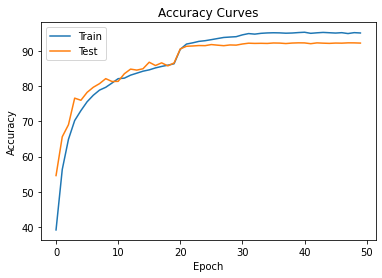

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_accs,label='Train')
ax.plot(test_accs, label='Test')

plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

## Misclassified Images

Display 25 misclassified test images

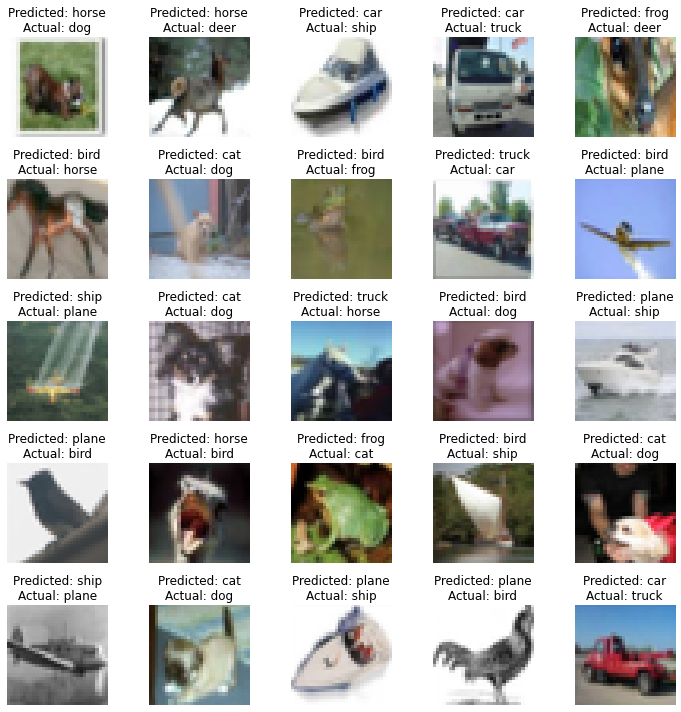

In [ ]:
plot_images(misclassified_imgs, data.classes, "misclassified_imgs.png")

## Visualize GradCam

Use GradCam to understand where the network is looking at while prediction

In [ ]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

### GradCam for correctly classified images

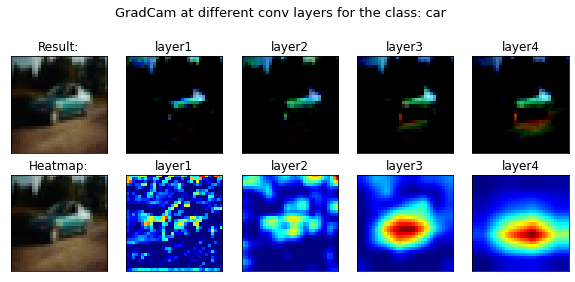

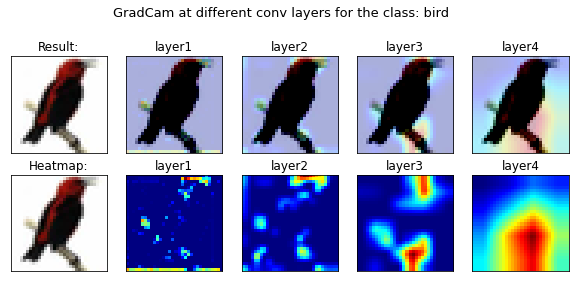

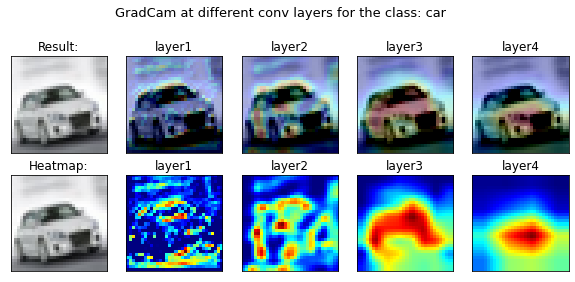

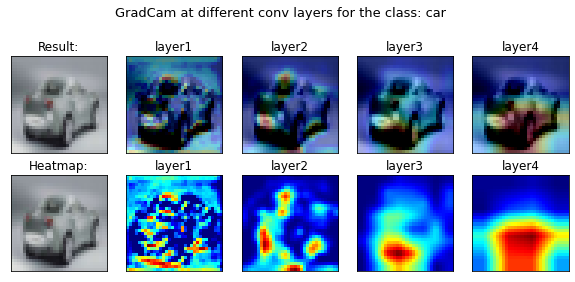

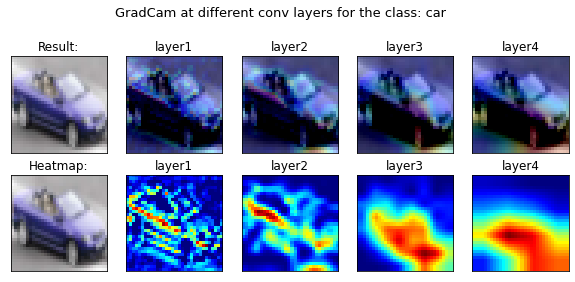

In [ ]:
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")

### GradCam for incorrectly classified images

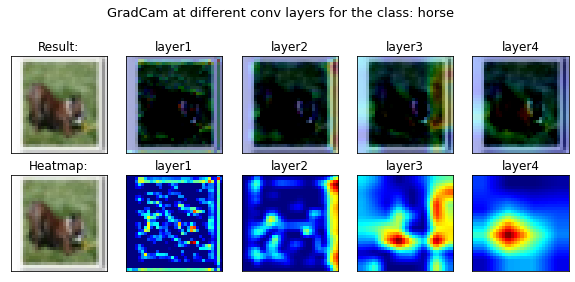

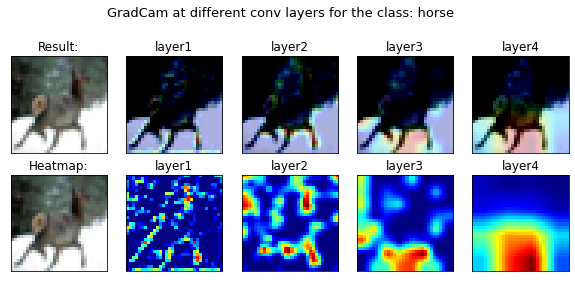

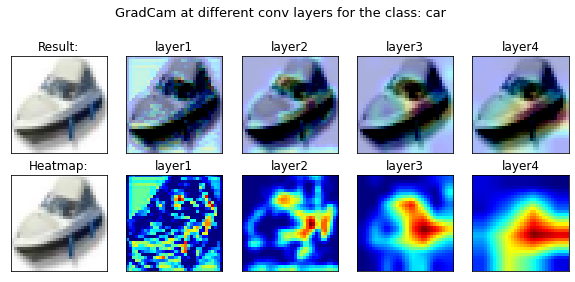

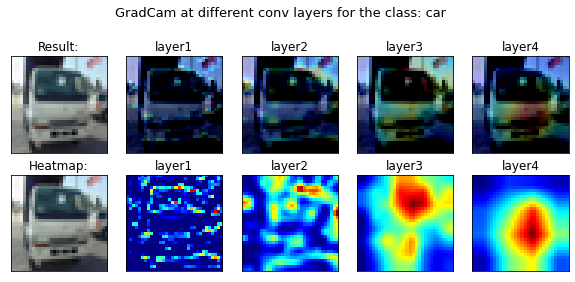

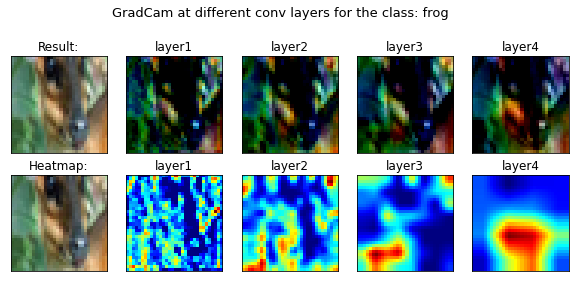

In [ ]:
incorrect_pred_imgs = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
viz_cam(torch.stack(incorrect_pred_imgs), target_layers, metric="incorrect")